# Fine-Tune HyenaDNA On A Downstream Classification Task

In this notebook, we will fine-tune the HynaDNA model on a downstream binary classification task involving cis-regulatory elements.

### Install the package

In [ ]:
# !pip install helical

### Imports

In [ ]:
from helical import HyenaDNA, HyenaDNAConfig, HyenaDNAFineTuningModel
from datasets import load_dataset
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import logging, warnings
import numpy as np

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

Make use of GPU if there is a GPU present, otherwise default to the CPU

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset Download

- We now use the Hugging Face API to download the [dataset](https://huggingface.co/datasets/InstaDeepAI/nucleotide_transformer_downstream_tasks_revised)
- We select the task from the list of tasks available for this dataset

In [3]:
label = "promoter_tata"
dataset_train = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks_revised", label, split="train", trust_remote_code=True)
dataset_test = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks_revised", label, split="test", trust_remote_code=True)

In [4]:
unique, counts = np.unique(dataset_train["label"], return_counts=True)
dict(zip(unique, counts))

{0: 2531, 1: 2531}

In [5]:
unique, counts = np.unique(dataset_test["label"], return_counts=True)
dict(zip(unique, counts))

{0: 106, 1: 106}

Since this is a binary classification task, only 2 labels are present below

### Define our HyenaDNA fine-tuning model and configs

In [6]:
hyena_config = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256", batch_size=10, device=device)
hyena_fine_tune = HyenaDNAFineTuningModel(hyena_config, fine_tuning_head="classification", output_size=len(np.unique(dataset_train["label"])))

### Process the dataset for both training and testing

In [7]:
train_dataset = hyena_fine_tune.process_data(dataset_train["sequence"])
test_dataset = hyena_fine_tune.process_data(dataset_test["sequence"])

Processing sequences: 100%|██████████| 212/212 [00:00<00:00, 9641.03it/s]


### Fine-tune the model

For this we set our training and validation datasets along with their labels

In [9]:
hyena_fine_tune.train(train_input_data=train_dataset, train_labels=dataset_train["label"], validation_input_data=test_dataset, validation_labels=dataset_test["label"], epochs=10, optimizer_params={"lr": 2e-6}, lr_scheduler_params={"name": "linear", "num_warmup_steps": 0, "num_training_steps": 10})

Fine-Tuning Validation: 100%|██████████| 22/22 [00:00<00:00, 716.93it/s, val_loss=0.324]


### Evaluate the fine-tuned model

We now get the outputs of the model on our test dataset and display some results

In [10]:
outputs = hyena_fine_tune.get_outputs(test_dataset)

100%|██████████| 22/22 [00:00<00:00, 782.08it/s]


In [11]:
print(classification_report(dataset_test["label"], outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       106
           1       0.88      0.87      0.87       106

    accuracy                           0.87       212
   macro avg       0.87      0.87      0.87       212
weighted avg       0.87      0.87      0.87       212



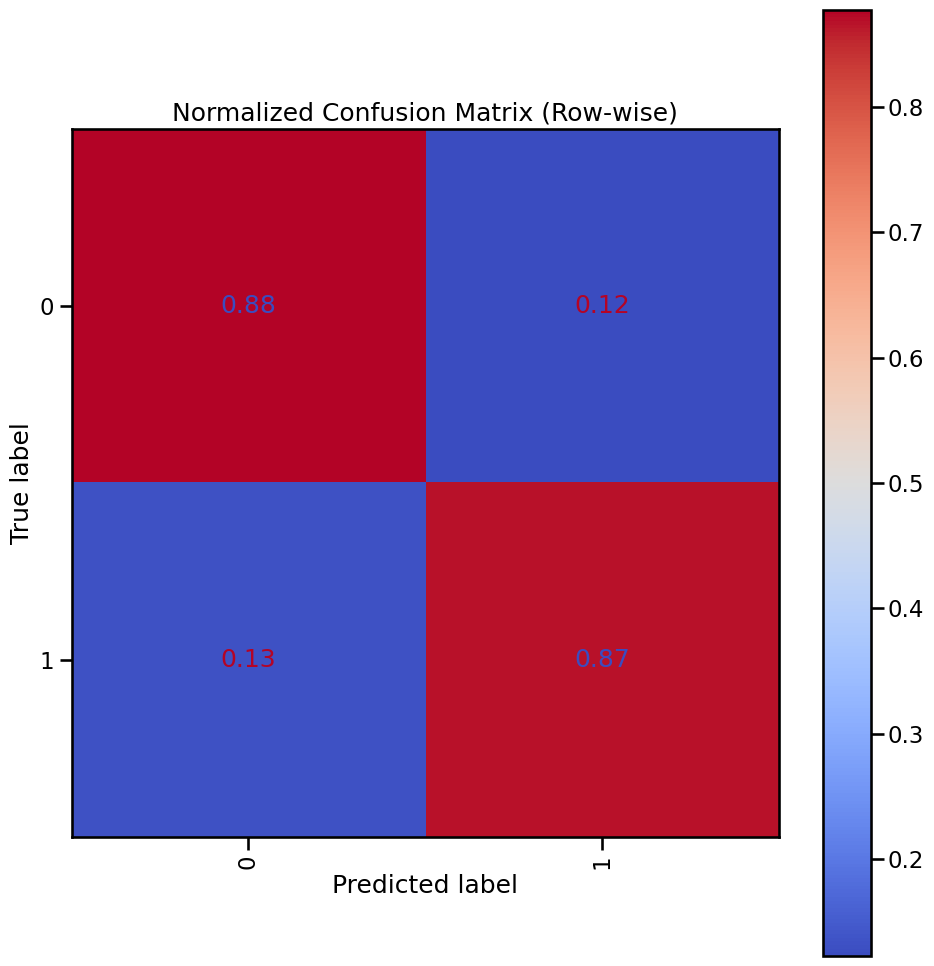

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(dataset_test["label"], outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((dataset_test["label"], outputs.argmax(axis=1))))

# Create and plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=unique_labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()